In [1]:
#  functions 
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

torch.set_printoptions(sci_mode=False)

# Set a random seed
seed_value = 420  # You can change this to any integer value

# Set the random seed for PyTorch
torch.manual_seed(seed_value)

# If you are using CUDA (GPU), set the random seed for all GPUs
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.

# Optionally set the deterministic behavior for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def gauss(self, x, mean, sigma):
        return torch.exp(-(((x - mean) / sigma) ** 2))

def plot_gaussian_with_values(linspace, means, sigmas, input_values, input_number, membership_functions):
    """
    Plot the Gaussian membership functions for a given input number and mark the actual membership function values.
    """
    # Plot each membership function for the specified input
    for i in range(means.size(1)):
        y = gauss(linspace, means[input_number, i], sigmas[input_number, i])
        plt.plot(linspace.numpy(), y.numpy(), label=f'MF {i+1}')
        
        # Plot the actual input value's membership function activation
        membership_value = membership_functions[0, input_number, i]
        input_value = input_values[0, input_number]
        plt.scatter(input_value.item(), membership_value.item(), color='red', zorder=5)
        plt.text(input_value.item(), membership_value.item(), f'{membership_value.item():.2f}', 
                 fontsize=10, ha='right', color='red')

    plt.title(f'Gaussian Membership Functions for Input {input_number + 1}')
    plt.xlabel('x')
    plt.ylabel('MF value')
    plt.legend()
    plt.grid(True)
    plt.show()

# ANFIS Implementacja PyTorch

## Wprowadzenie

***Systemy neuronowo – rozmyte*** stanowią połączenie sieci neuronowych i systemów
rozmytych. Dzięki temu umożliwiają wykorzystanie zarówno regułowej reprezentacji
wiedzy systemów rozmytych jak i metod uczenia stosowanych w przypadku sieci
neuronowych.

Algorytm ***ANFIS*** jest jednym z przykładów algorytmu/implementacji systemów
neuronowo-rozmytych. Wykorzystuje on zarówno proces optymalizacji z wykorzystaniem
algorytmów gradientowych jak i algorytm propagacji wstecznej.

## Opis architektury

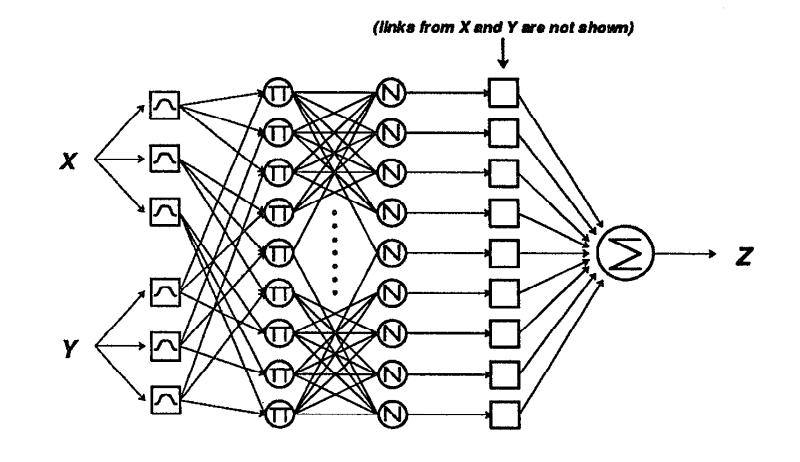
<br> ****Rysunek 1*** Architektura sieci*

Model składa się z 5 warstw. Początkowo dla każdego wejścia tworzone są sparametryzowane funkcje przynależnośći. Na podanym przykładzie dla wejść *x* oraz *y* mamy stworzone po 3 funkcje przynależności. Jako funkcji przynależności użyjemy funkcji gaussa. Trenując sieć parametry każdej funkcji będą odpowiednio optymalizowane. 

W kolejnej warstwie tworzone są kombinacje funkcji przynależności (zasady). W każdym takim nodzie stosowana jest operacja iloczynu rozmytego (np. minimum). 
Następnie wartości z poprzednich nodów są normalizowane (dzielone przez sumę wszystkich wartości). Końcowa warstwa Mnoży x oraz y z trenowalnymi parametrami oraz całość przemnaża przez siłę oddziaływania reguły z poprzedniego noda. Tak przeliczone wartości są sumowane ze sobą i w ten sposó otrzymujemy wynik.


## Symulacja działania sieci- operacje na tensorach

### Warstwa 1
Pierwsza warstwa jako wejście przyjmuje wektor wejściowy: [x1, x2, x3, x4, ...] (w naszym przypadku [x1, x2])
Parametry trenowalne tej warstwy to means oraz sigmas. Są to parametry danych funkcji przynależności do danego zbioru rozmytego. Możemy je zdefiniować wcześniej, np jeśli zmienna wejściowa to wzrost to wtedy definiujemy 3 zbiory- niski, średni oraz wysoki dobierając w tym celu odpowiednie parametry początkowe. 
W ten sposób sieć odpowiednio dostroi te parametry póżniej. możemy także zainicjalizować je losowo. Warstwa na wyjście podaje wyliczone wartości funkcji przynależności. W naszym przypadku mamy po 3 funkcje na każde z 2 wejść, co daje nam 6 parametrów mean oraz 6 parametrów sigma. Funkcja ta posiada w tym przypadku 6 nodów. <br>
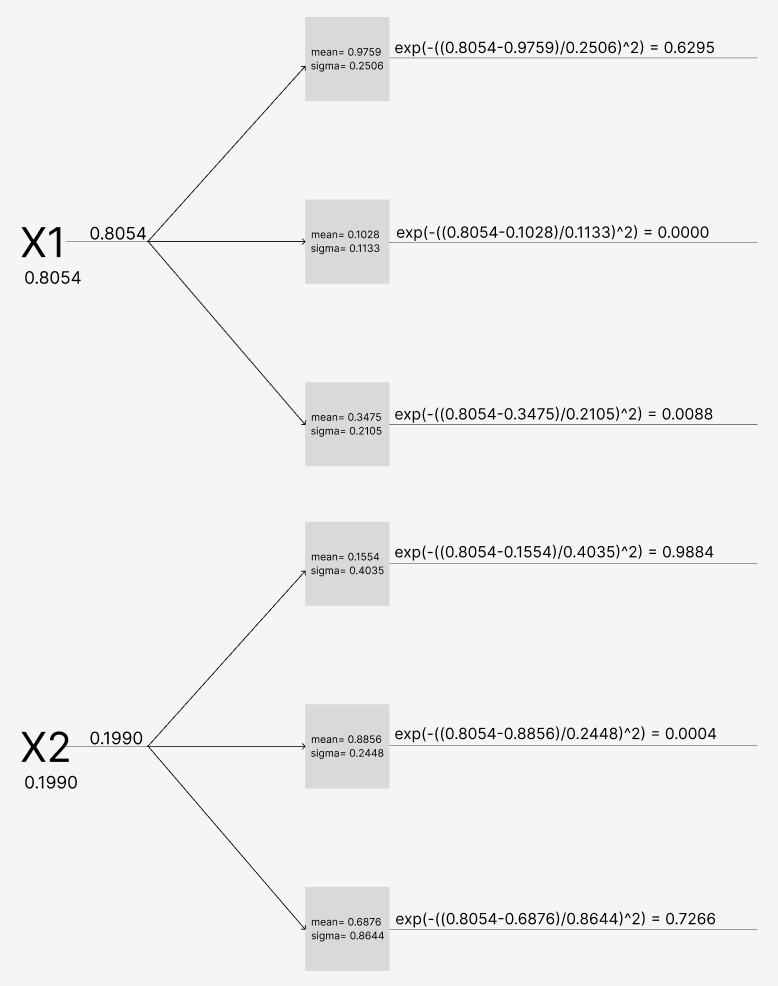 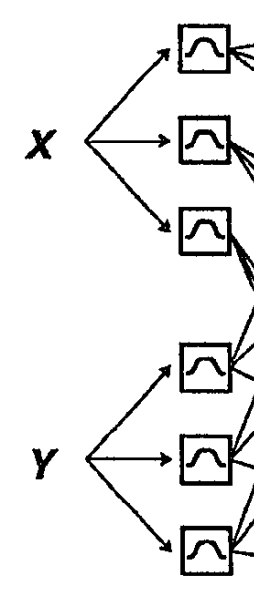

In [2]:
batch_size = 1
number_of_inputs = 2
number_of_membership_functions = 3
number_of_outputs = 1

torch.manual_seed(420)

#  input data
input = torch.rand(batch_size,number_of_inputs)
print(f"input: {input}")

# layer 1
print("---layer1---")
means = torch.rand(number_of_inputs, number_of_membership_functions)
print(f"means: {means}")

sigmas = torch.rand(number_of_inputs, number_of_membership_functions)
print(f"sigmas: {sigmas}")

def gauss(x, a, b):
    return torch.exp(-(((x - a) / b) ** 2))

membership_functions = gauss(input.unsqueeze(2), means, sigmas)
print(f"membership functions: {membership_functions}")

input: tensor([[0.8054, 0.1990]])
---layer1---
means: tensor([[0.9759, 0.1028, 0.3475],
        [0.1554, 0.8856, 0.6876]])
sigmas: tensor([[0.2506, 0.1133, 0.2105],
        [0.4035, 0.2448, 0.8644]])
membership functions: tensor([[[    0.6295,     0.0000,     0.0088],
         [    0.9884,     0.0004,     0.7266]]])


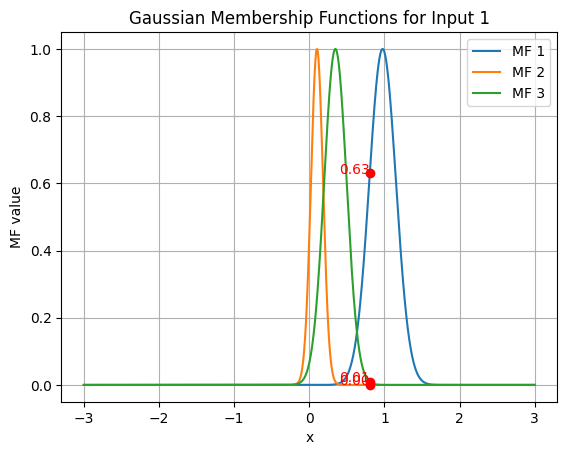

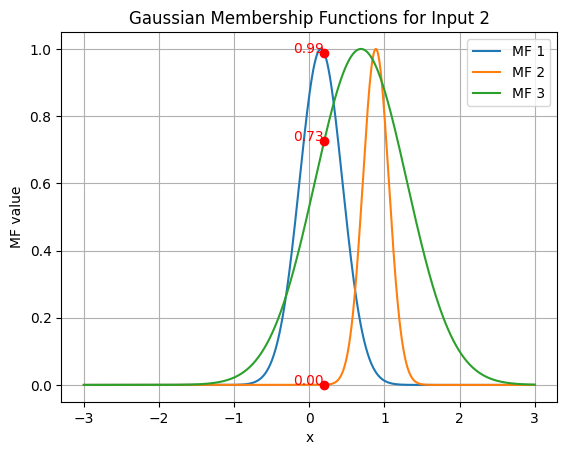

In [3]:
linspace = torch.linspace(-3, 3, 1000)
plot_gaussian_with_values(linspace, means, sigmas, input, 0, membership_functions)
plot_gaussian_with_values(linspace, means, sigmas, input, 1, membership_functions)

### Warstwa 2
Warstwa ta łączy funkcje przynależności z poprzedniej warstwy w celu utworzenia reguł. Łączy je w następujący sposób- każda funkcja z każdego wejścia z każdą funkcją z każdego innego wejścia. Zatem w naszym przypadku będzie ona miała 9 nodów. Następnie przeprowadza ona operację iloczynu pomiędzy wartościami funkcji przynależności. Jako wyjście podaje wyliczony iloczyn. <br> 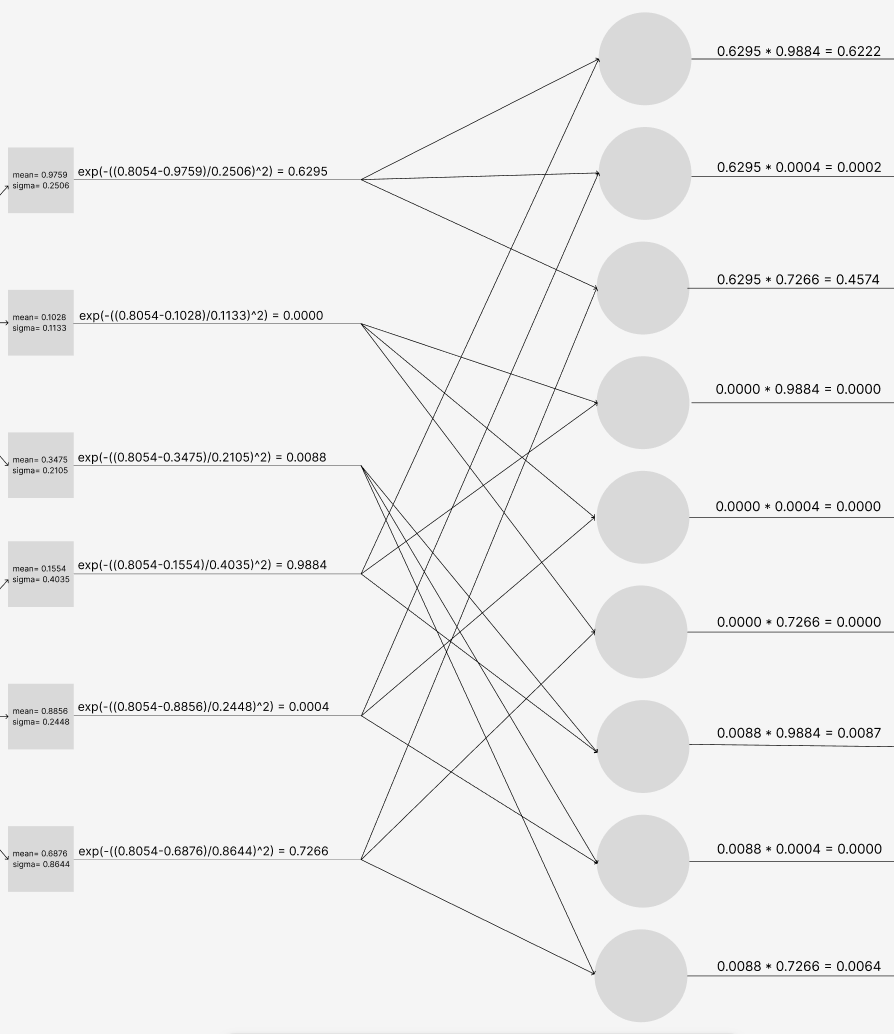 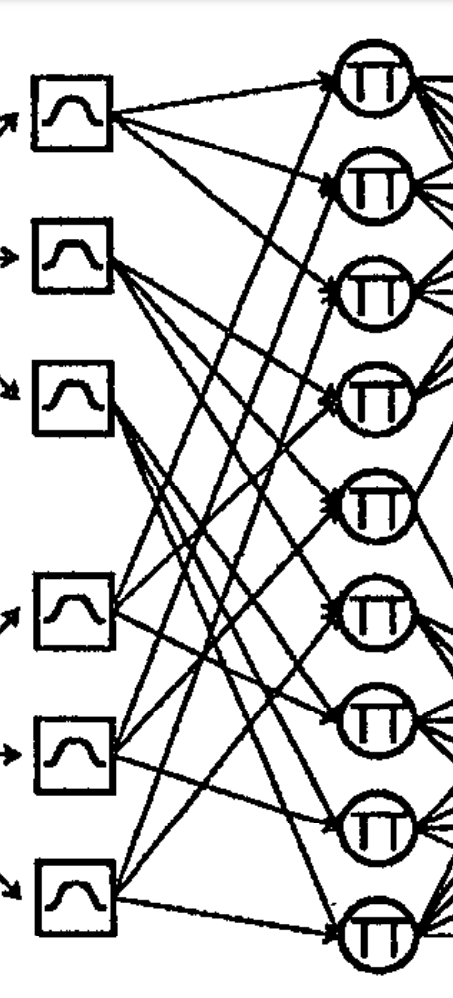

In [4]:
# layer 2
print("---layer2---")
consequent_layer_size = number_of_membership_functions**number_of_inputs
firing_strengths = []

for input_number in range(batch_size):
    firing_strength = torch.zeros(consequent_layer_size)
    index = 0

    for i1 in range(number_of_inputs):
        for j1 in range(number_of_membership_functions):
            for i2 in range(i1 + 1, number_of_inputs):
                for j2 in range(number_of_membership_functions):
                    firing_strength[index] = torch.mul(membership_functions[input_number][i1][j1], membership_functions[input_number][i2][j2])
                    index += 1

    firing_strengths.append(firing_strength)


firing_strengths = torch.stack(firing_strengths)
print(f"firing strengths of rules: {firing_strengths}")

---layer2---
firing strengths of rules: tensor([[    0.6222,     0.0002,     0.4574,     0.0000,     0.0000,     0.0000,
             0.0087,     0.0000,     0.0064]])


### Warstwa 3
Jako wejścia warstwa ta przyjmuje wartości oddziaływania reguł wyliczone w poprzedniej warstwie. Następnei każdą taką wartość dzieli przez sumę wszystkich wartości- normalizuje. Jako wyjście podaje znormalizowane wartości siły oddziaływania danej reguły. <br> 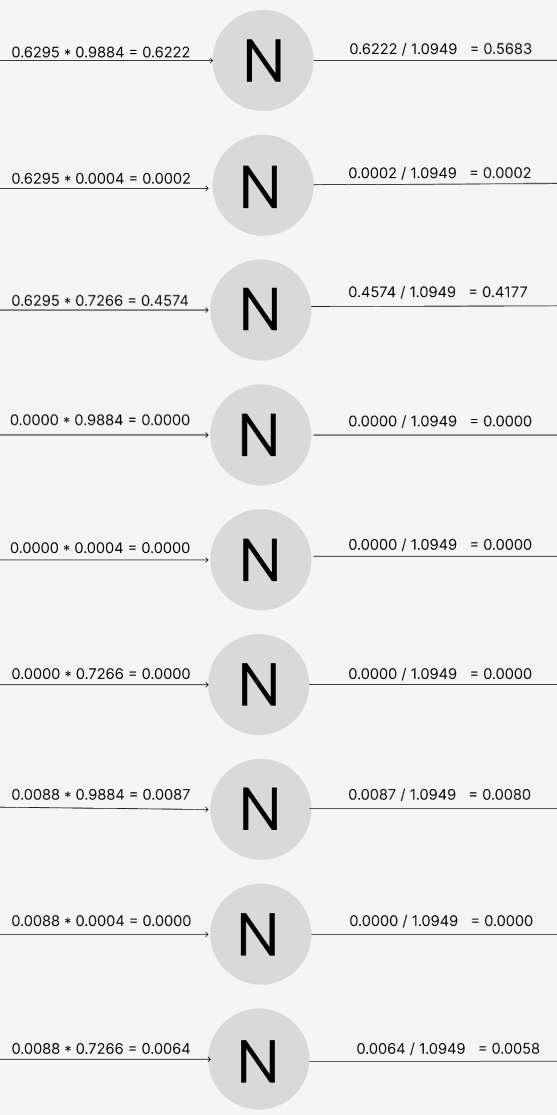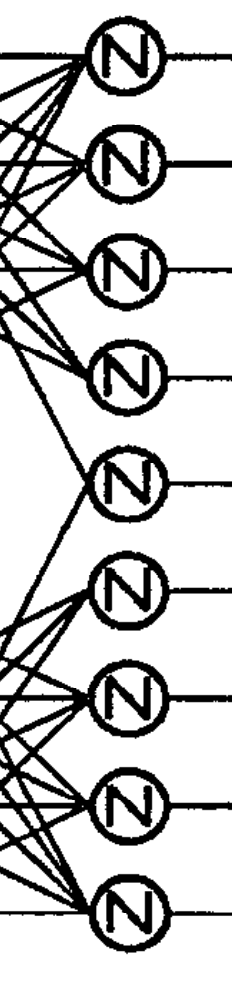

In [5]:
# layer 3
print("---layer3---")
firing_strengths_sum = torch.sum(firing_strengths, dim=1)
print(f"firing strengts sum: {firing_strengths_sum}")
normalized_firing_strengths = firing_strengths / firing_strengths_sum.unsqueeze(1)
print(f"normalized firing strengths of rules: {normalized_firing_strengths}")

---layer3---
firing strengts sum: tensor([1.0949])
normalized firing strengths of rules: tensor([[    0.5683,     0.0002,     0.4177,     0.0000,     0.0000,     0.0000,
             0.0080,     0.0000,     0.0058]])


### Warstwa 4
Ta warstwa jako wejście przyjmuje znormalziowane siły oddziaływania reguł oraz czyste wejścia- w tym przpyadku x1 oraz x2. 
Trenowalne parametry to wagi: po 2 na każdy neuron (po 1 dla każdej zmiennej wejściowej) oraz biasy po 1 na każdy neuron. 
Następnie wyjście wyliczane jest według wzoru: znormalizowana siła oddziaływania reguły * (waga1 * x1 + waga2 * x2 + bias). <br>
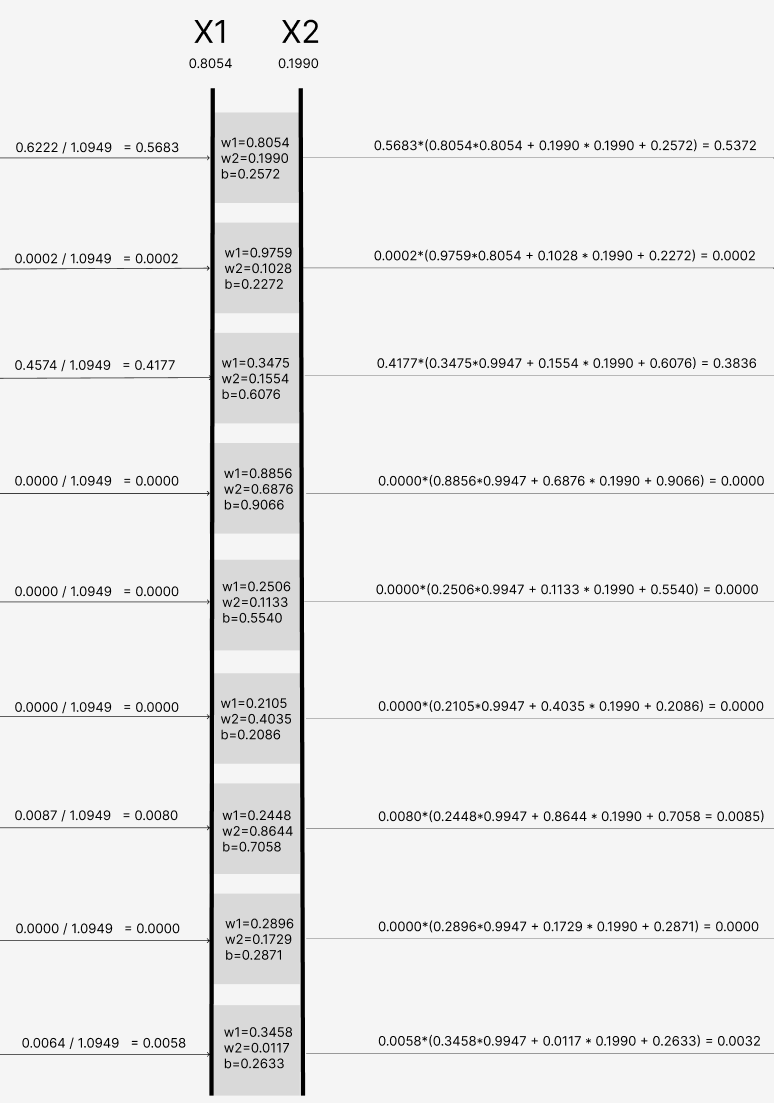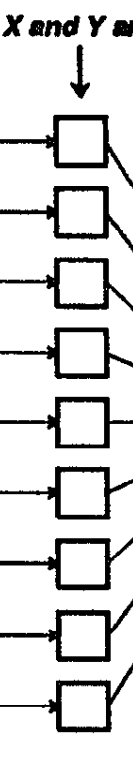

In [6]:
torch.manual_seed(420)
# layer 4
print("---layer4---")
consequent_weights = torch.rand(batch_size, consequent_layer_size, number_of_inputs)
print(f"consequent weigths: {consequent_weights}")

consequent_biases = torch.rand(batch_size, consequent_layer_size, 1)
print(f"consequent biases: {consequent_biases}")

outputs = input.unsqueeze(1) * consequent_weights
outputs = torch.sum(outputs, dim=2).unsqueeze(2)
outputs = outputs + consequent_biases
outputs = outputs.squeeze()
print(f"outputs: {outputs}")

outputs_weighted_by_strengths = outputs * normalized_firing_strengths
print(f"outputs weighted: {outputs_weighted_by_strengths}")


---layer4---
consequent weigths: tensor([[[0.8054, 0.1990],
         [0.9759, 0.1028],
         [0.3475, 0.1554],
         [0.8856, 0.6876],
         [0.2506, 0.1133],
         [0.2105, 0.4035],
         [0.2448, 0.8644],
         [0.2896, 0.1729],
         [0.3458, 0.0117]]])
consequent biases: tensor([[[0.2572],
         [0.2272],
         [0.6076],
         [0.9066],
         [0.5540],
         [0.2086],
         [0.7058],
         [0.2871],
         [0.2633]]])
outputs: tensor([0.9454, 1.0336, 0.9184, 1.7567, 0.7784, 0.4584, 1.0750, 0.5548, 0.5441])
outputs weighted: tensor([[    0.5372,     0.0002,     0.3836,     0.0000,     0.0000,     0.0000,
             0.0085,     0.0000,     0.0032]])


### Warstwa 5 
Jest to warstwa wyjściowa w naszym przypadku mamy tylko jedno wyjście. Tutaj po prostu sumujemy wartości z poprzednej warstwy. Jako wynik otrzymujemy jedną wartość.<br>
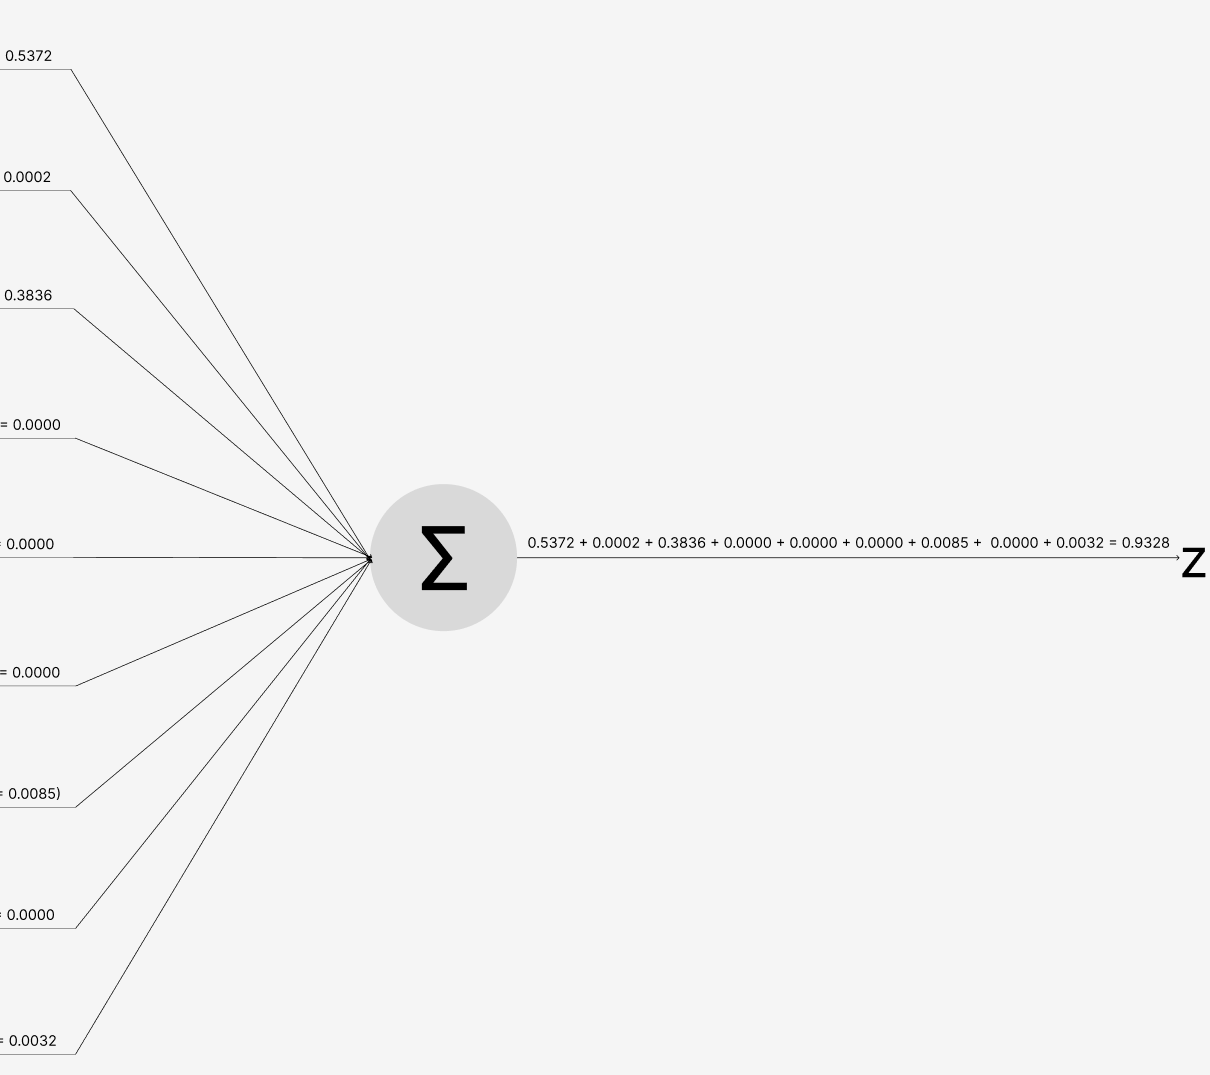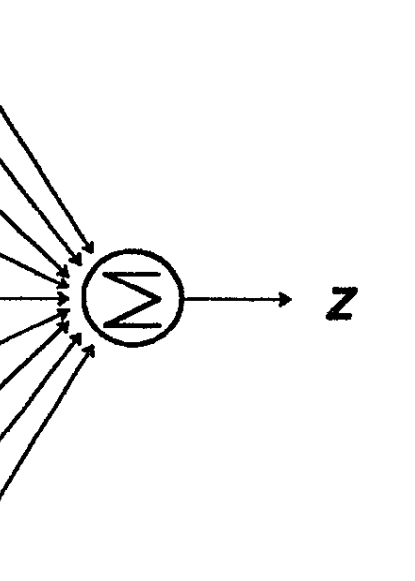

In [7]:
# layer 5
print("---layer5---")
summed_output = torch.sum(outputs_weighted_by_strengths, dim=1)
print(f"summed output: {summed_output}")

---layer5---
summed output: tensor([0.9328])


## Implementacja PyTorch

In [8]:
class ANFISMembershipFunctionLayer(nn.Module):
    def __init__(self, input_dim, num_membership_functions, mean = None, sigma = None):
        super(ANFISMembershipFunctionLayer, self).__init__()

        self.mean = nn.Parameter(torch.rand(input_dim, num_membership_functions)) if mean == None else nn.Parameter(mean)
        self.sigma = nn.Parameter(torch.rand(input_dim, num_membership_functions)) if sigma == None else nn.Parameter(sigma)

    def gauss(self, x, mean, sigma):
        return torch.exp(-(((x - mean) / sigma) ** 2))
    
    def forward(self, x):
        membership_functions = self.gauss(x.unsqueeze(2), self.mean, self.sigma)
        return membership_functions
    
class ANFISRuleStrengthLayer(nn.Module):
    def __init__(self, number_of_inputs, number_of_membership_functions):
        super(ANFISRuleStrengthLayer, self).__init__()
        self.number_of_inputs = number_of_inputs
        self.number_of_membership_functions = number_of_membership_functions
        self.consequent_layer_size = number_of_membership_functions**number_of_inputs

    def forward(self, x):
        batch_size = x.size(0)

        firing_strengths = []

        for input_number in range(batch_size):
            firing_strength = torch.zeros(self.consequent_layer_size)
            index = 0

            for i1 in range(self.number_of_inputs):
                for j1 in range(self.number_of_membership_functions):
                    for i2 in range(i1 + 1, self.number_of_inputs):
                        for j2 in range(self.number_of_membership_functions):
                            firing_strength[index] = torch.mul(x[input_number][i1][j1], x[input_number][i2][j2])
                            index += 1

            firing_strengths.append(firing_strength)

        firing_strengths = torch.stack(firing_strengths)
        return firing_strengths

class ANFISRuleStrengthNormalizationLayer(nn.Module):
    def __init__(self):
        super(ANFISRuleStrengthNormalizationLayer, self).__init__()

    
    def forward(self, x):
        firing_strengths_sum = torch.sum(x, dim=1)
        normalized_firing_strengths = x / firing_strengths_sum.unsqueeze(1)

        return normalized_firing_strengths
    
class ANFISConsequentLayer(nn.Module):
    def __init__(self, consequent_layer_size, number_of_inputs, consequent_weights=None, consequent_biases=None):
        super(ANFISConsequentLayer, self).__init__()

        self.consequent_weights = nn.Parameter(torch.rand(consequent_layer_size, number_of_inputs)) if consequent_weights == None else nn.Parameter(consequent_weights)
        self.consequent_biases = nn.Parameter(torch.rand(consequent_layer_size, 1)) if consequent_biases == None else nn.Parameter(consequent_biases)

    def forward(self, x, plain_input):
        outputs = plain_input.unsqueeze(1) * self.consequent_weights.unsqueeze(0)
        outputs = torch.sum(outputs, dim=2).unsqueeze(2)
        outputs = outputs + self.consequent_biases.unsqueeze(0)
        outputs = outputs.squeeze()

        outputs_weighted_by_strengths = outputs * x

        return outputs_weighted_by_strengths

    
class ANFISOutputSingle(nn.Module):
    def __init__(self, consequent_layer_size):
        super(ANFISOutputSingle, self).__init__()

        self.consequent_layer_size = consequent_layer_size

    def forward(self, x):
        summed_output = torch.sum(x, dim=1)
        return summed_output
    
class ANFIS(nn.Module):
    def __init__(self, number_of_features=2, number_of_membership_functions=3, number_of_outputs=1, mean=None, sigma=None, consequent_weights=None, consequent_biases=None):
        super(ANFIS, self).__init__()
        self.number_of_features = number_of_features
        self.consequent_layer_size = number_of_membership_functions**number_of_features
        self.membership_function_layer = ANFISMembershipFunctionLayer(number_of_features, number_of_membership_functions, mean, sigma)
        self.rule_strength_layer = ANFISRuleStrengthLayer(number_of_features, number_of_membership_functions)
        self.rule_strength_normalization_layer = ANFISRuleStrengthNormalizationLayer()
        self.consequent_layer = ANFISConsequentLayer(self.consequent_layer_size, number_of_features, consequent_weights, consequent_biases)
        
        if number_of_outputs == 1:
            self.output = ANFISOutputSingle(self.consequent_layer_size)
        else: 
            self.output = nn.Linear(self.consequent_layer_size, number_of_outputs)            

    def forward(self, x):
        membership_functions = self.membership_function_layer(x)
        rule_strengths = self.rule_strength_layer(membership_functions)
        normalized_rule_strengths = self.rule_strength_normalization_layer(rule_strengths)
        consequent_outputs = self.consequent_layer(normalized_rule_strengths, x)
        output = self.output(consequent_outputs)
        return output
    
    def gauss(self, x, mean, sigma):
        return torch.exp(-(((x - mean) / sigma) ** 2))
    
    def plot_gaussian_with_values(self, linspace=torch.linspace(-3,3,1000)):
        means = self.membership_function_layer.mean
        sigmas = self.membership_function_layer.sigma
        for input_number in range(self.number_of_features):
            # Plot each membership function for the specified input
            for i in range(means.size(1)):
                y = gauss(linspace, means[input_number, i], sigmas[input_number, i])
                plt.plot(linspace.numpy(), y.detach().numpy(), label=f'MF {i+1}')

            plt.title(f'Gaussian Membership Functions for Input {input_number + 1}')
            plt.xlabel('x')
            plt.ylabel('MF value')
            plt.legend()
            plt.grid(True)
            plt.show()

    


In [9]:
# Example parameters for the ANFIS model
number_of_features = 2            # Number of input features
number_of_inputs = 2              # Number of inputs to the ANFIS
number_of_membership_functions = 3  # Number of membership functions per input
number_of_outputs = 1             # Single output (regression task)

# Initialize the ANFIS model
anfis_model = ANFIS(
    number_of_features=number_of_features,
    number_of_membership_functions=number_of_membership_functions,
    number_of_outputs=number_of_outputs
)


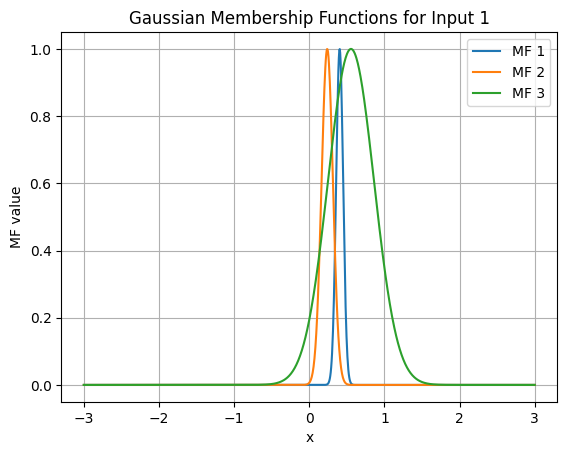

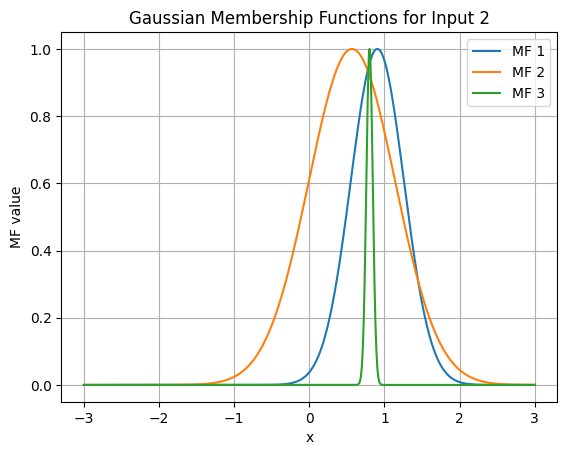

In [10]:
anfis_model.plot_gaussian_with_values()

In [11]:
# Example input with batch size 1
input_batch_1 = torch.tensor([[0.5, 0.3]])  # Shape: (1, 2), one input with two features

# Perform inference
output_batch_1 = anfis_model(input_batch_1)
print("Output with batch size 1:", output_batch_1)

Output with batch size 1: tensor([0.4631], grad_fn=<SumBackward1>)


In [12]:
# Example input with batch size 3
input_batch_3 = torch.tensor([
    [0.5, 0.3], 
    [0.1, 0.4], 
    [0.9, 0.7]
])  # Shape: (3, 2), three inputs with two features each

# Perform inference
output_batch_3 = anfis_model(input_batch_3)
print("Output with batch size 3:", output_batch_3)


Output with batch size 3: tensor([0.4631, 0.6537, 0.8121], grad_fn=<SumBackward1>)


In [13]:
anfis_model.state_dict()

OrderedDict([('membership_function_layer.mean',
              tensor([[0.4042, 0.2391, 0.5550],
                      [0.9059, 0.5682, 0.8020]])),
             ('membership_function_layer.sigma',
              tensor([[0.0656, 0.1067, 0.4335],
                      [0.5005, 0.8121, 0.0603]])),
             ('consequent_layer.consequent_weights',
              tensor([[0.7086, 0.0708],
                      [0.5807, 0.8304],
                      [0.5690, 0.6596],
                      [0.8179, 0.9947],
                      [0.1862, 0.6638],
                      [0.9116, 0.7843],
                      [0.0471, 0.1532],
                      [0.0103, 0.7213],
                      [0.9947, 0.0157]])),
             ('consequent_layer.consequent_biases',
              tensor([[0.8998],
                      [0.0322],
                      [0.4390],
                      [0.9057],
                      [0.4214],
                      [0.5555],
                      [0.8645],
             

## Trenowanie sieci

Kod trenujący sieć ANFIS znajduje się w katalogu `anfis_training_scripts`